In [15]:
import numpy as np
quantiles = [1.0, 0.5, 0.1, 0.05]
MCMC_PATH = "/Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/cli_gk/results/mcmc/"
true_datas = np.load(MCMC_PATH + "mcmc_true.npz", allow_pickle=True)
all_datas = {"true": true_datas}
for quantile in quantiles:
    all_datas[quantile] = {}
    for marginal in [0,1,2,3,-1]:
        all_datas[quantile][marginal] = np.load(MCMC_PATH + f"mcmc_marginal_{marginal}_quantile_{quantile}.npz", allow_pickle=True)

n_marginals = 4
par_names = ["$A$", "$B$", "$g$", "$k$"]
model_name = "gk"


In [31]:
import numpy as np
from abcnre.inference import load_estimator_from_yaml
ESTIMATOR_PATH = "/Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/cli_gk/results/estimators/"
estimators = {}
for quantile in quantiles:
    estimators[quantile] = {}
    for marginal in [0,1,2,3,-1]:
        estimators[quantile][marginal] = load_estimator_from_yaml(ESTIMATOR_PATH + f"estimator_marginal_{marginal}_quantile_{quantile}/estimator.yaml")
        


In [39]:
import jax

key = jax.random.PRNGKey(0)
for marginal in [0,1,2,3,-1]:
    estimator = estimators[1.0][marginal]
    cov = estimator.simulator.check_summary_stats_correlation(key, n_samples = 10000)
    print(f"Covariance for marginal {marginal}: {cov}")

Covariance for marginal 0: [0.97924995]
Covariance for marginal 1: [0.8864538]
Covariance for marginal 2: [0.61905056]
Covariance for marginal 3: [0.95061153]
Covariance for marginal -1: [0.9788526 0.8860472 0.6431336 0.9489126]


In [4]:
def get_samples(data, method, n_samples = 10000):
    samples =  dict(data[method].item())["samples"]
    n_total_samples = samples.shape[0]
    return samples[::n_total_samples // n_samples]

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_marginals(all_datas, estimators, abc = True, nre = True, correct_nre = True, true = True, n_samples=10000, save = True):
    file_name = f"results/plots/marginal_joint_{model_name}"
    for quantile in quantiles:
        f, ax = plt.subplots(1,4, figsize=(20, 5))
        if nre: 
            joint_nre = get_samples(all_datas[quantile][-1], "nre_standard", n_samples=n_samples)
            for i in range(n_marginals):
                sns.kdeplot(joint_nre[:, i].flatten(), ax=ax[i], label="Joint NRE", color="red", linestyle="--")
                sns.kdeplot(get_samples(all_datas[quantile][i], "nre_standard", n_samples=n_samples).flatten(), ax=ax[i], label=f"Marginal NRE", color = "red")
            file_name+= "_nre"
        if correct_nre:
            joint_correct_nre = get_samples(all_datas[quantile][-1], "nre_corrected", n_samples=n_samples)
            for i in range(n_marginals):
                sns.kdeplot(joint_correct_nre[:, i].flatten(), ax=ax[i], label="Joint Corrected NRE", color="blue", linestyle="--")
                sns.kdeplot(get_samples(all_datas[quantile][i], "nre_corrected", n_samples=n_samples).flatten(), ax=ax[i], label=f"Marginal Corrected NRE", color="blue")
            file_name+= "_corrected_nre"
        if abc: 
            joint_abc = estimators[quantile][-1].stored_phis
            for i in range(n_marginals):
                marginal_abc = estimators[quantile][i].stored_phis
                sns.kdeplot(joint_abc[:n_samples, i].flatten(), ax=ax[i], label="Joint ABC", color="orange", linestyle="--") 
                sns.kdeplot(marginal_abc[:n_samples].flatten(), ax=ax[i], label=f"Marginal ABC", color="orange")
            file_name+= "_abc"
        if true: 
            true_samples = get_samples(all_datas["true"], "true_posterior", n_samples=n_samples)
            for i in range(n_marginals):
                sns.kdeplot(true_samples[:, i].flatten(), ax=ax[i], label="True Posterior", color = "green")
        for i in range(n_marginals):
            ax[i].set_xlim(-0.1, 5.1)
            ax[i].set_xlabel(par_names[i])
        plt.suptitle(f"Marginal and Joint NRE for $\epsilon =$ {quantile:.0%}")
        plt.legend()
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        if save: plt.savefig(file_name + f"_quantile_{quantile}.png")

        plt.show()
        
def plot_quantiles(all_datas, estimators, abc = True, nre = True, correct_nre = True, true = True, n_samples=10000, save = True, xlims = None, marginal = False, joint = True):
    file_name = f"results/plots/marginal_joint_{model_name}"
    f, ax = plt.subplots(1,n_marginals, figsize=(20, 5))
    for quantile in quantiles:
        if nre: 
            joint_nre = get_samples(all_datas[quantile][-1], "nre_standard", n_samples=n_samples)
            for i in range(n_marginals):
                if joint:sns.kdeplot(joint_nre[:, i].flatten(), ax=ax[i], label=f"Joint NRE $\epsilon =$ {quantile:.0%}", color="red", linestyle="--")
                if marginal: sns.kdeplot(get_samples(all_datas[quantile][i], "nre_standard", n_samples=n_samples).flatten(), ax=ax[i], label=f"Marginal NRE $\epsilon =$ {quantile:.0%}", color = "red")
            file_name+= "_nre"
        if correct_nre:
            joint_correct_nre = get_samples(all_datas[quantile][-1], "nre_corrected", n_samples=n_samples)
            for i in range(n_marginals):
                if joint: sns.kdeplot(joint_correct_nre[:, i].flatten(), ax=ax[i], label=f"Joint Corrected NRE $\epsilon =$ {quantile:.0%}", color="blue", linestyle="--")
                if marginal:sns.kdeplot(get_samples(all_datas[quantile][i], "nre_corrected", n_samples=n_samples).flatten(), ax=ax[i], label=f"Marginal Corrected NRE $\epsilon =$ {quantile:.0%}", color="blue")
            file_name+= "_corrected_nre"
        if abc: 
            joint_abc = estimators[quantile][-1].stored_phis
            for i in range(n_marginals):
                marginal_abc = estimators[quantile][i].stored_phis
                if joint: sns.kdeplot(joint_abc[:n_samples, i].flatten(), ax=ax[i], label=f"Joint ABC $\epsilon =$ {quantile:.0%}", linestyle="--") 
                if marginal: sns.kdeplot(marginal_abc[:n_samples].flatten(), ax=ax[i], label=f"Marginal ABC $\epsilon =$ {quantile:.0%}")
            file_name+= "_abc"
        if true: 
            true_samples = get_samples(all_datas["true"], "true_posterior", n_samples=n_samples)
            for i in range(n_marginals):
                sns.kdeplot(true_samples[:, i].flatten(), ax=ax[i], label="True Posterior", color = "green")
        for i in range(n_marginals):
            ax[i].set_xlabel(par_names[i])
            ax[i].set_xlim(-0.1, 5.1)
    # plt.suptitle(f"Marginal and Joint NRE for $\epsilon =$ {quantile:.0%}")
    plt.legend()
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    # if save: plt.savefig(file_name + f"_quantile_{quantile}.png")

    plt.show()

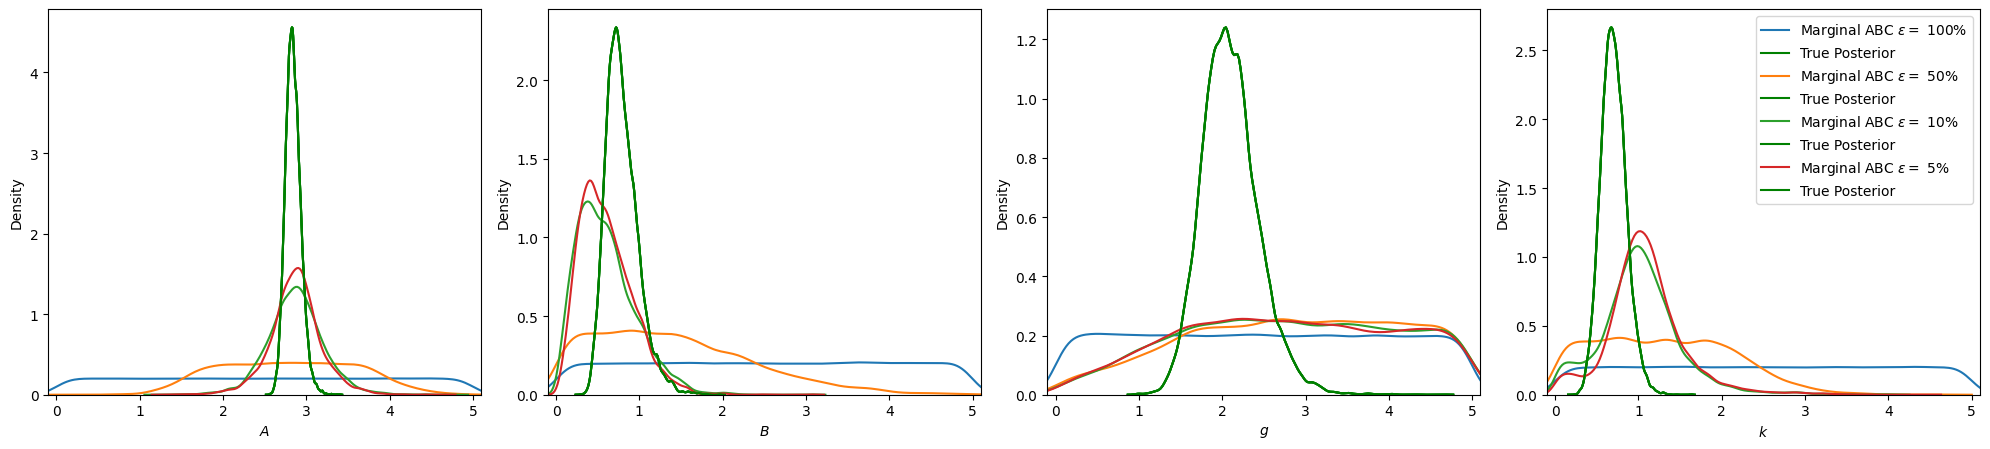

In [41]:
plot_quantiles(all_datas, estimators, abc = True, nre = False, correct_nre = False, true = True, n_samples=100000, marginal=True, joint=False)

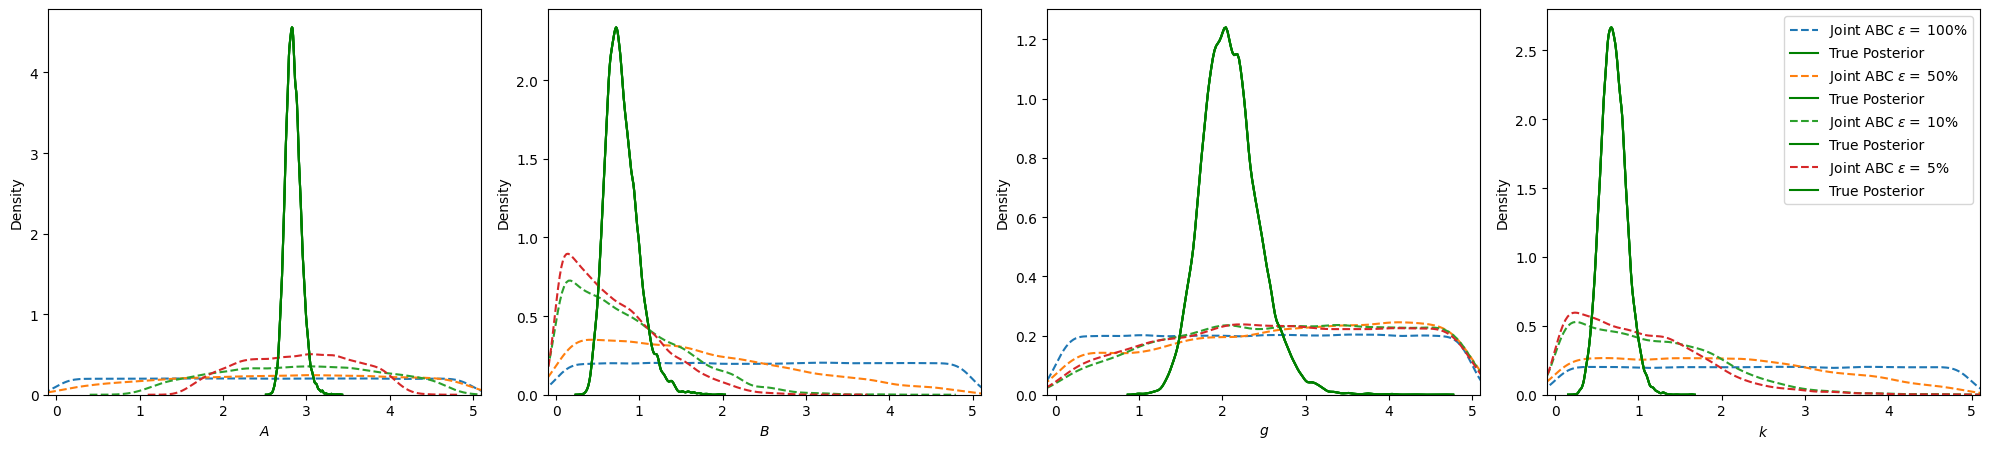

In [42]:
plot_quantiles(all_datas, estimators, abc = True, nre = False, correct_nre = False, true = True, n_samples=100000, marginal=False, joint=True)

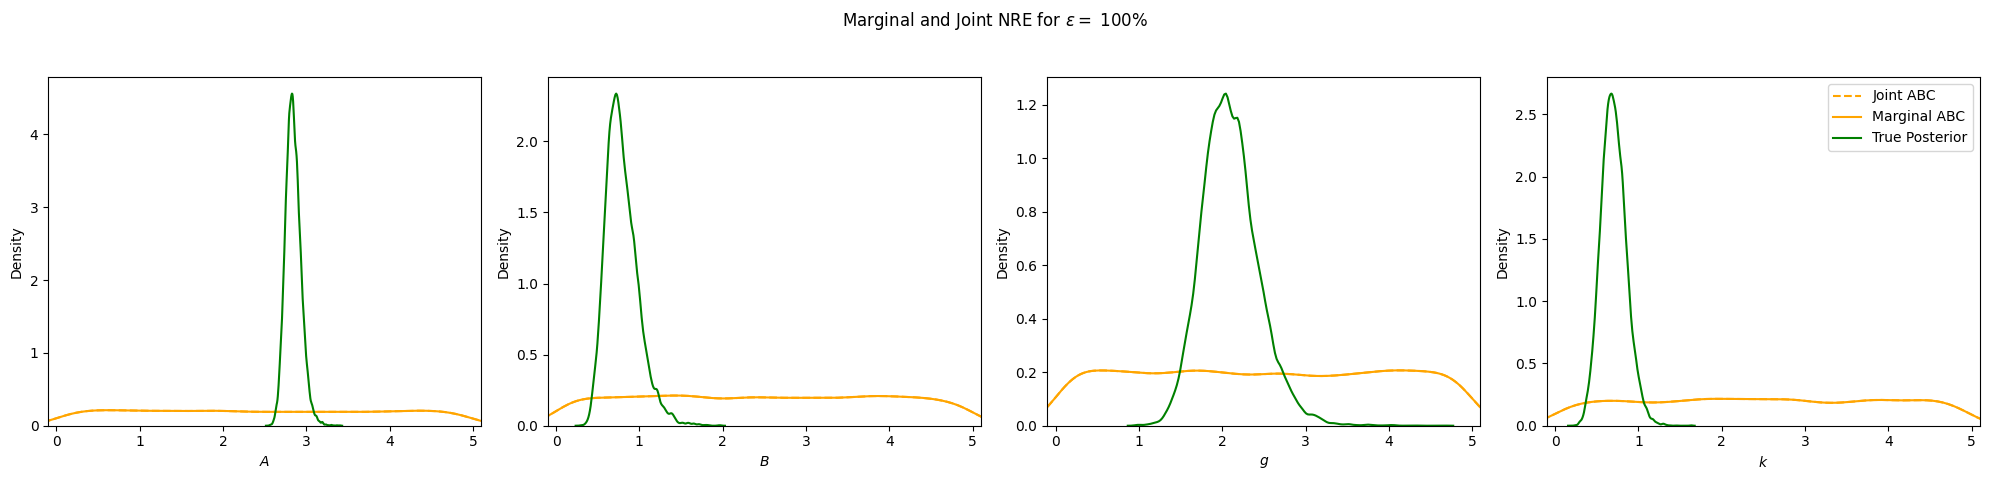

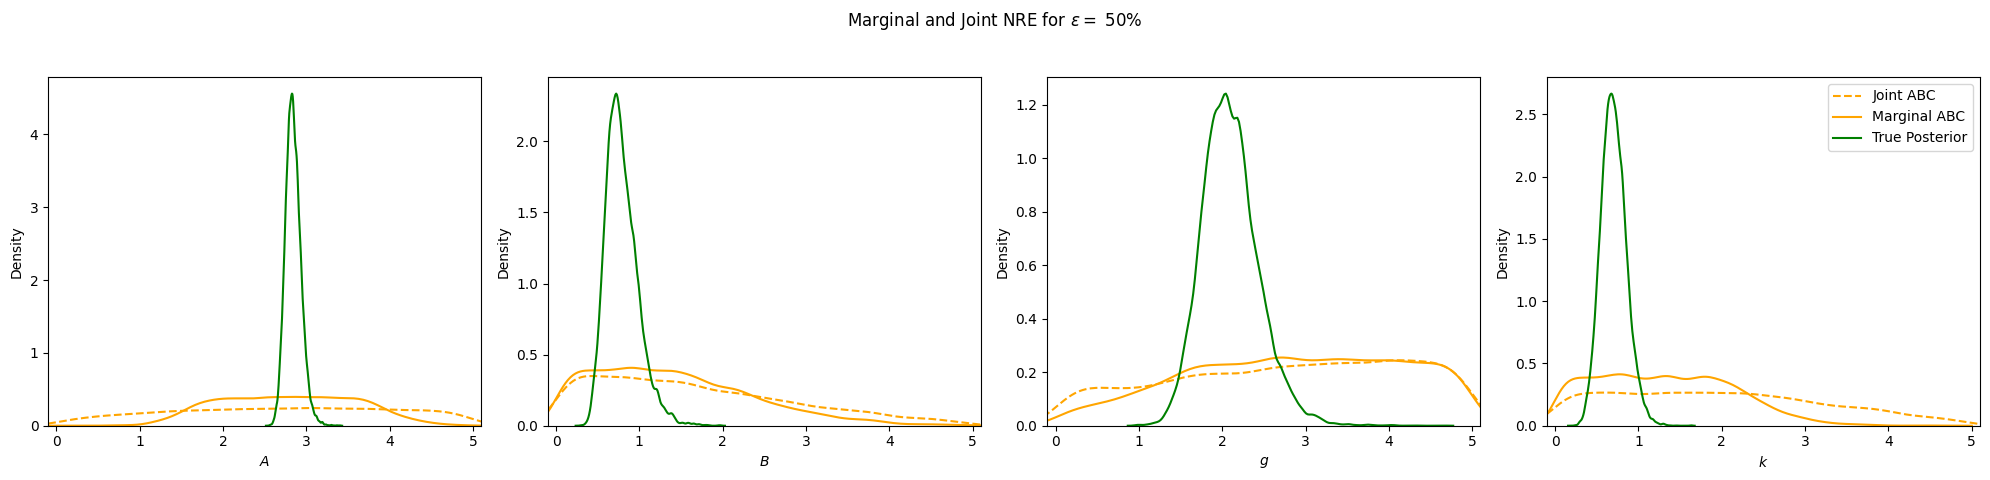

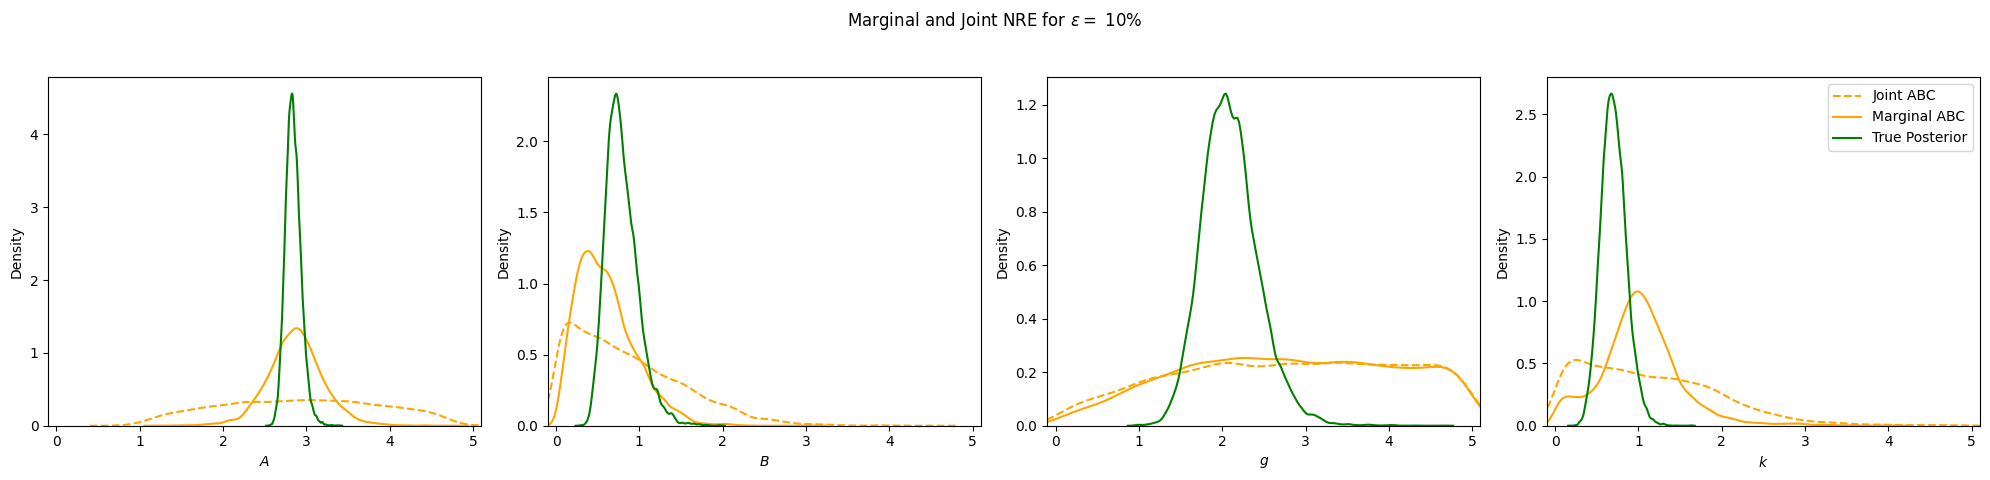

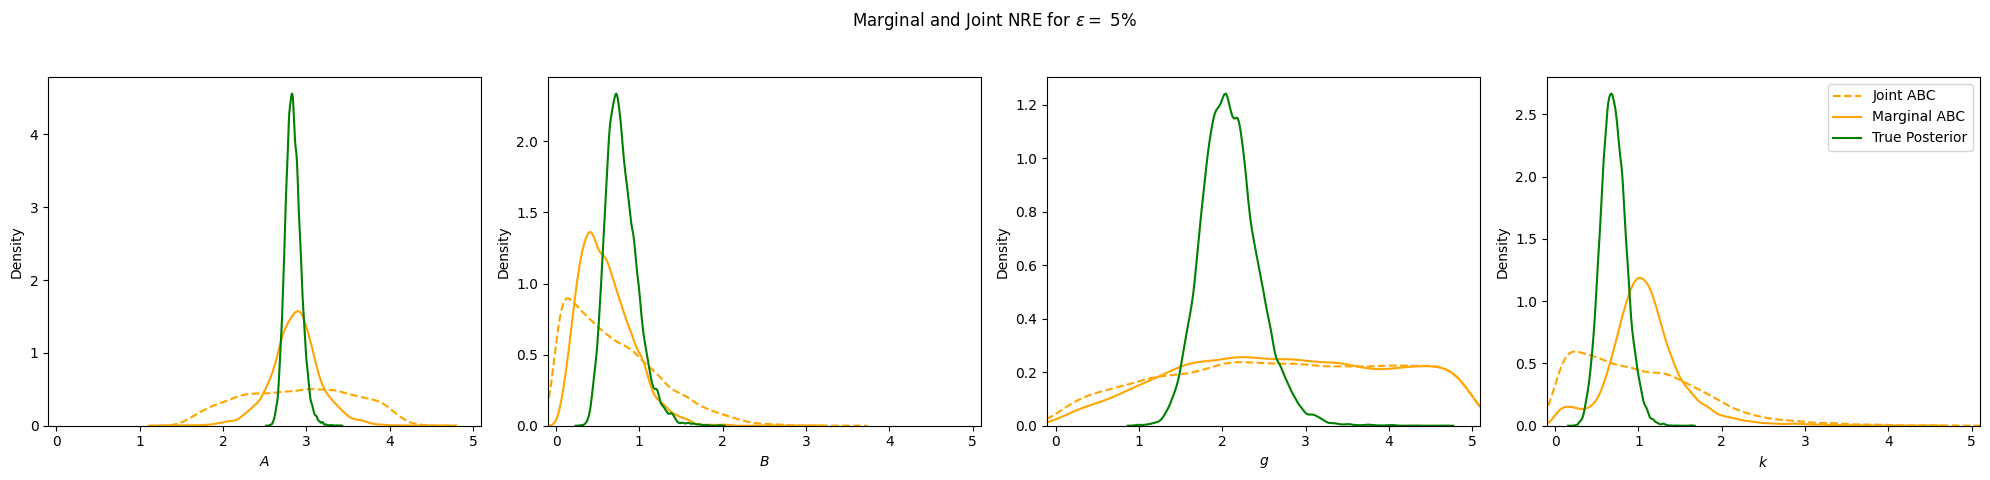

In [6]:
plot_marginals(all_datas, estimators, abc = True, nre = False, correct_nre = False, true = True, n_samples=100000)

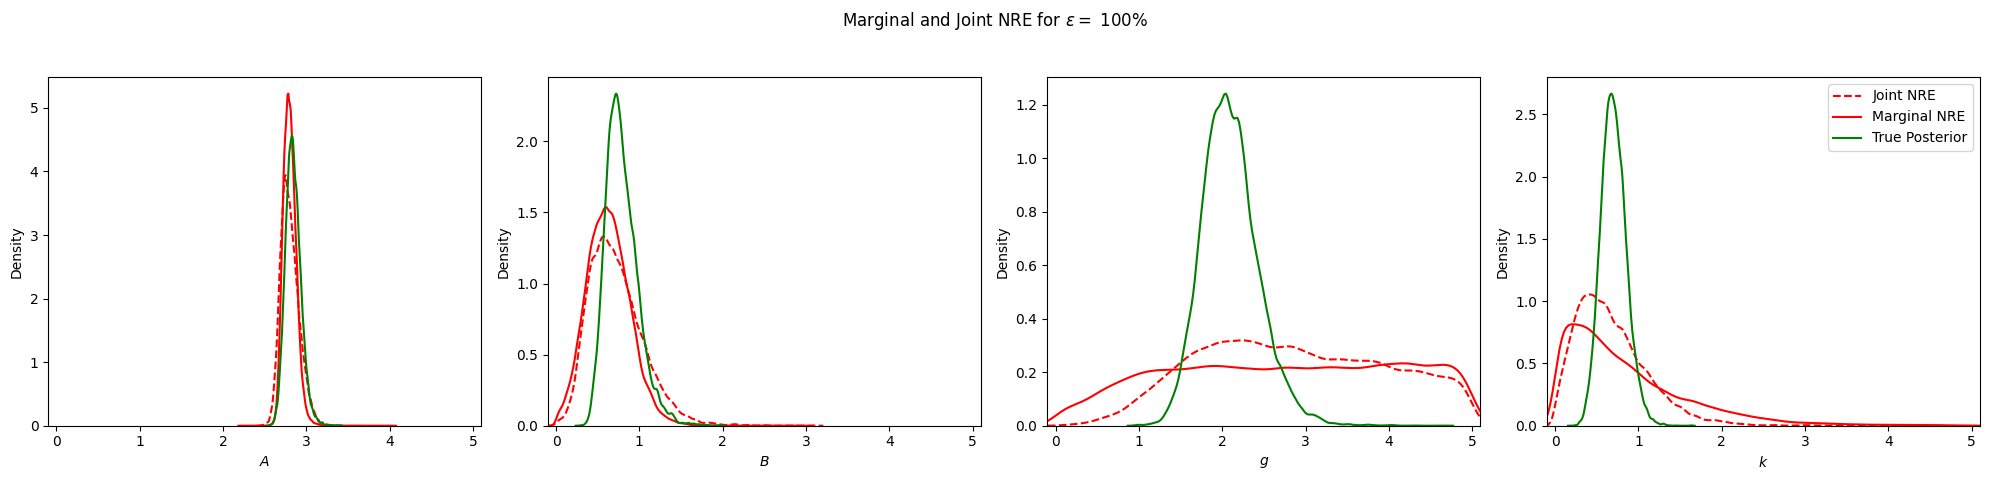

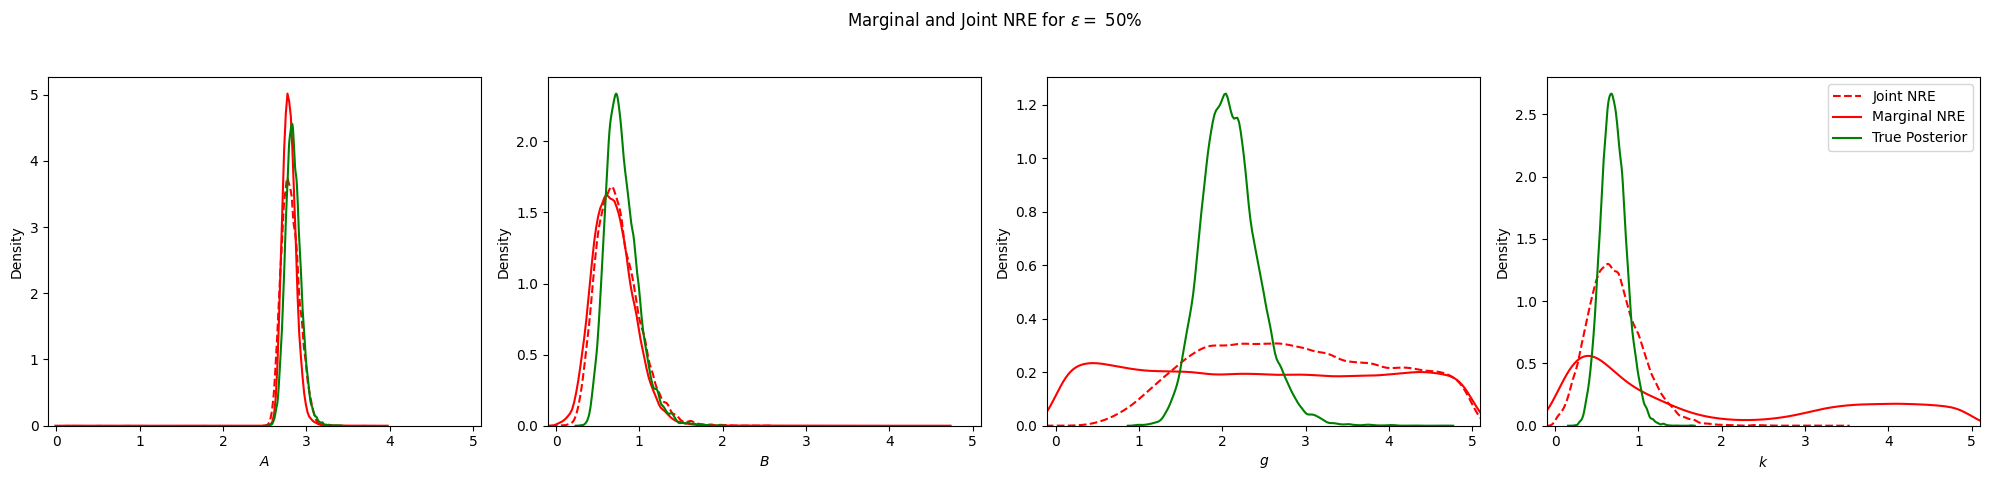

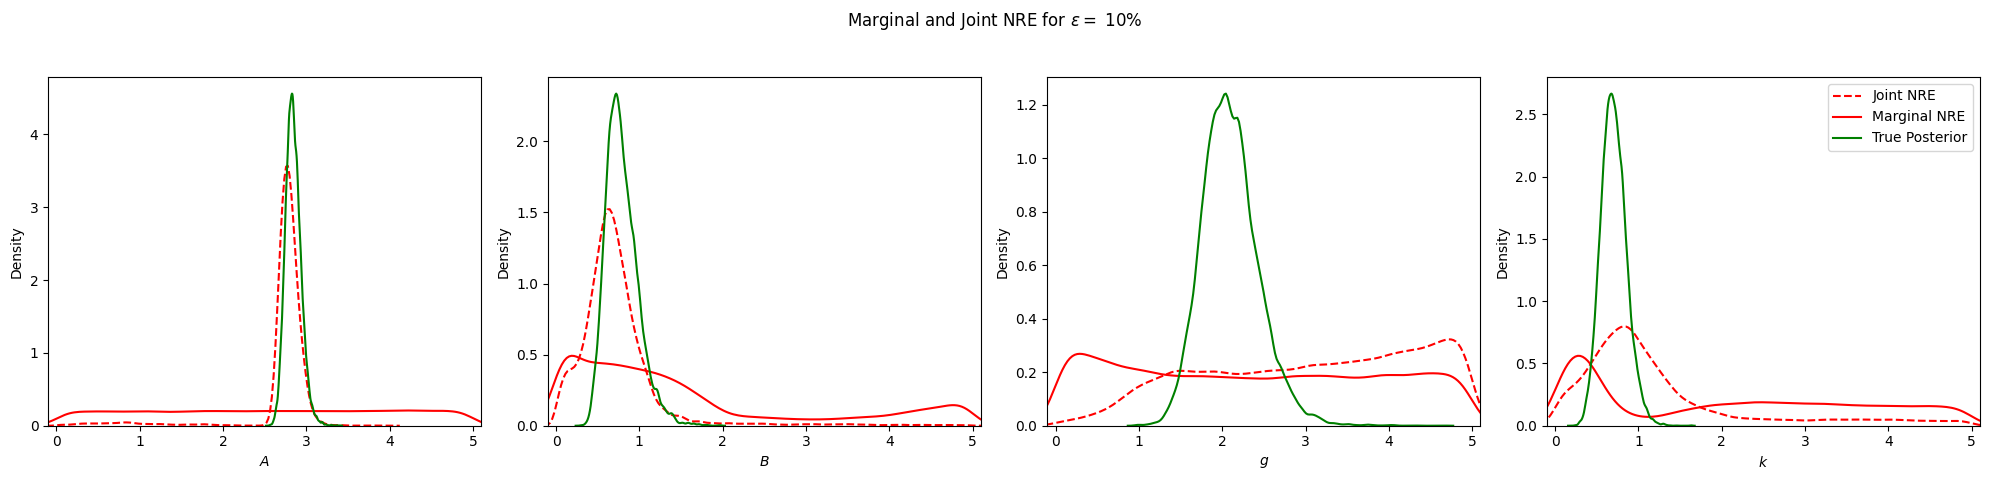

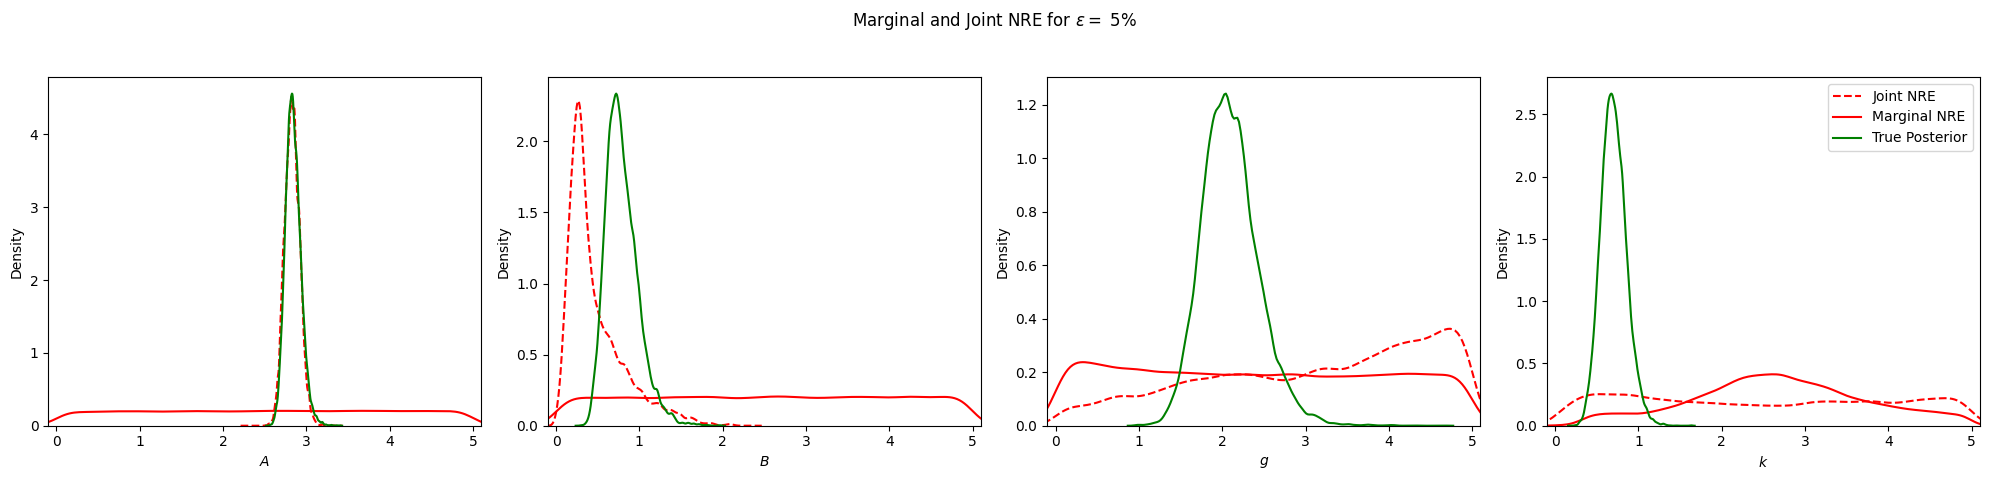

In [7]:
plot_marginals(all_datas, estimators, abc = False, nre = True, correct_nre = False, true = True, n_samples=100000)

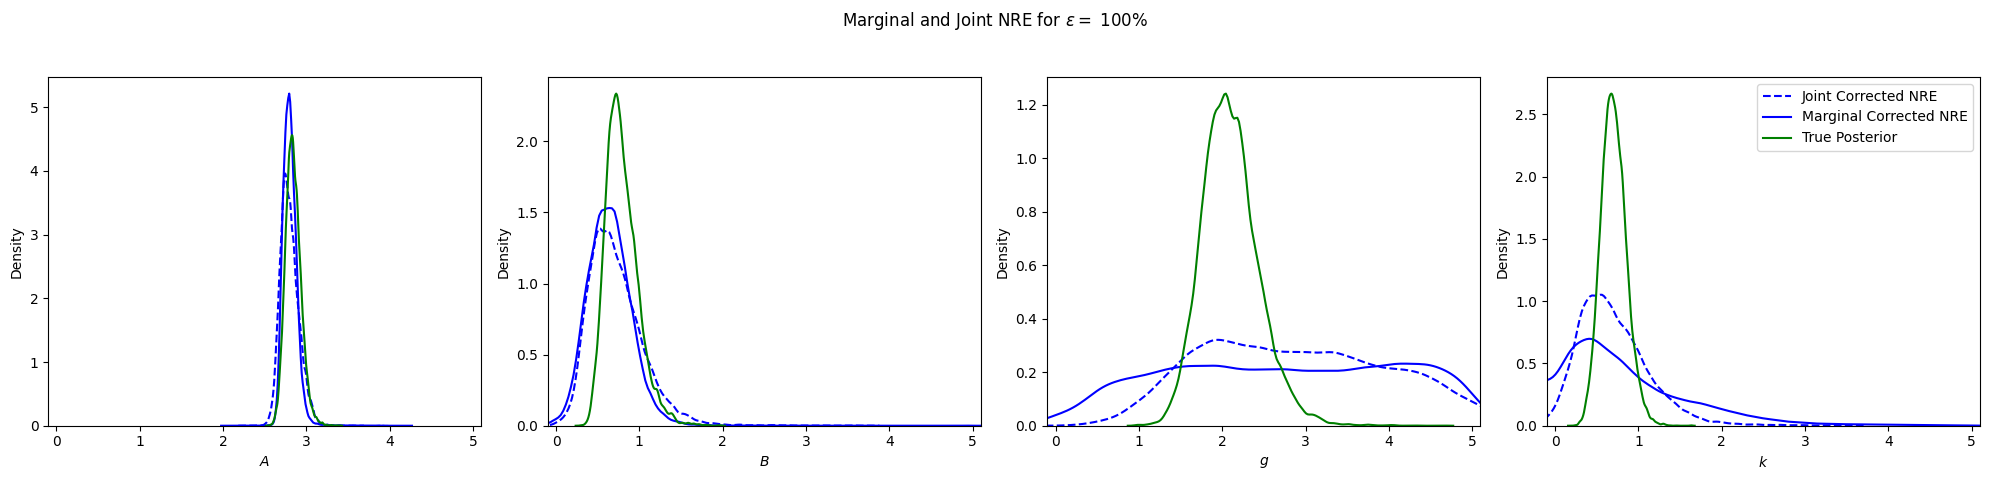

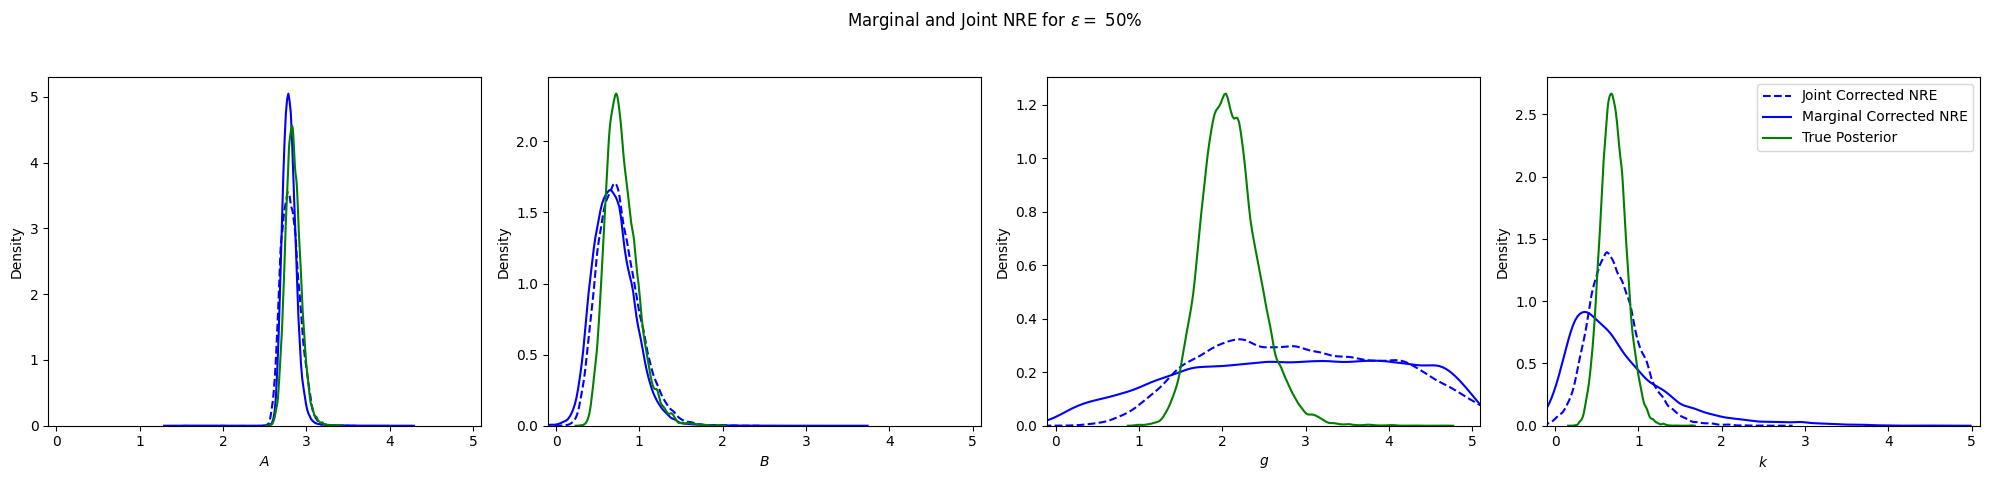

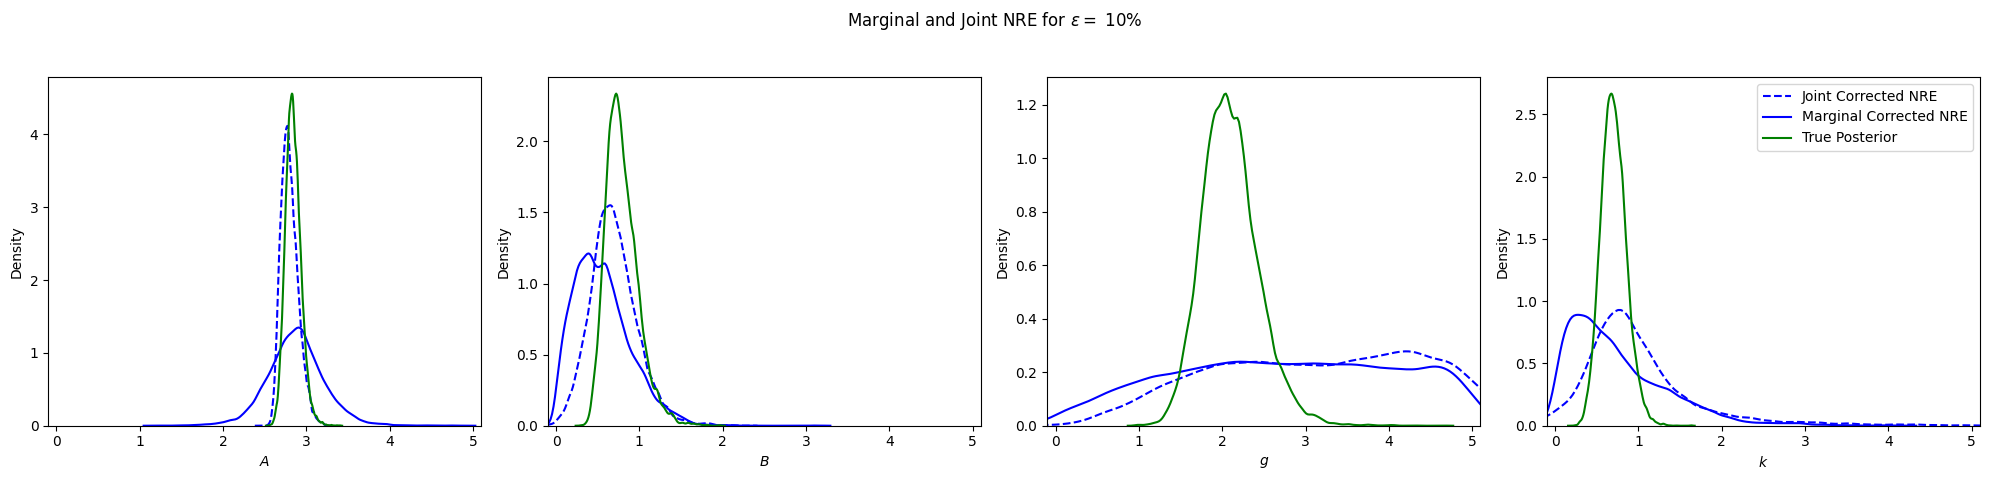

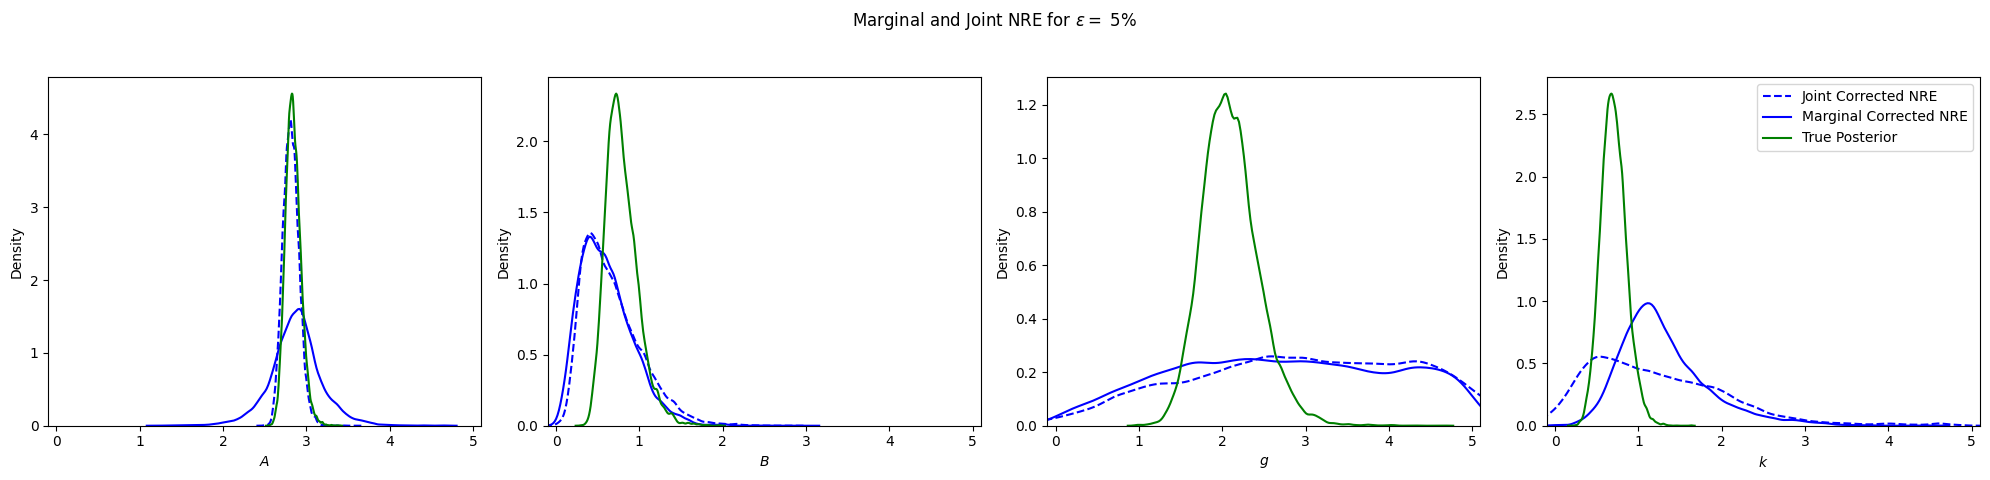

In [8]:
plot_marginals(all_datas, estimators, abc = False, nre = False, correct_nre = True, true = True, n_samples=100000)